# Analyzing Airport Data

**Author: Hope Ugwuoke**

In this project I studied the data from all the flights in the US from September 1st to September 30th of 2021. I got this data from the Bureau of Transportation Statistics. 

The nodes are aiports and the edges are flights. There are about 18,000 edges. The network is weighted because there are several flights (such as 100 or 200) flights between any two airports each month. 

The network is directed because the flight come from an origin and have an end destination. Sometimes the weight becomes balenced because flights may come from an airport and then return to the airport. 

When the weights are balenced the arrow is not visible. Yet there are some arrows in the image because some airports do not reciprocate. As in there are flights from the airport but no flights to the airport.   

The first step was getting the data from the bureau of labor statistics and importing it into a networkx graph. 

In [2]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
with open('Airport data.txt', 'r') as Flightdata:
    originlist = []
    destinationlist = []
    for i, row in enumerate(Flightdata): 
        rowlist = row.split('|')
        originlist.append(rowlist[5])
        destinationlist.append(rowlist[16])

nodelist = np.unique(originlist)
flight_counts = pd.crosstab(originlist, destinationlist,dropna=False)
flight_counts = flight_counts.fillna(0)
for index in flight_counts.index: 
    if index in flight_counts.columns:
        continue
    else:
        flight_counts[index]=np.zeros(435)

## Initial plots of the Data

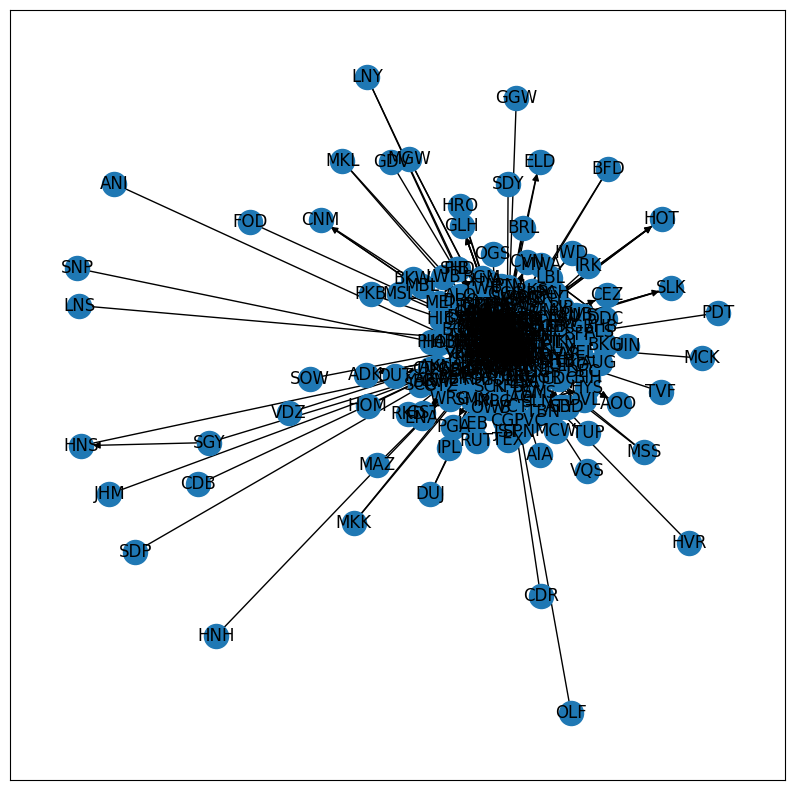

In [6]:
G = nx.from_pandas_adjacency(flight_counts,create_using=nx.DiGraph)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx(G)

<AxesSubplot: >

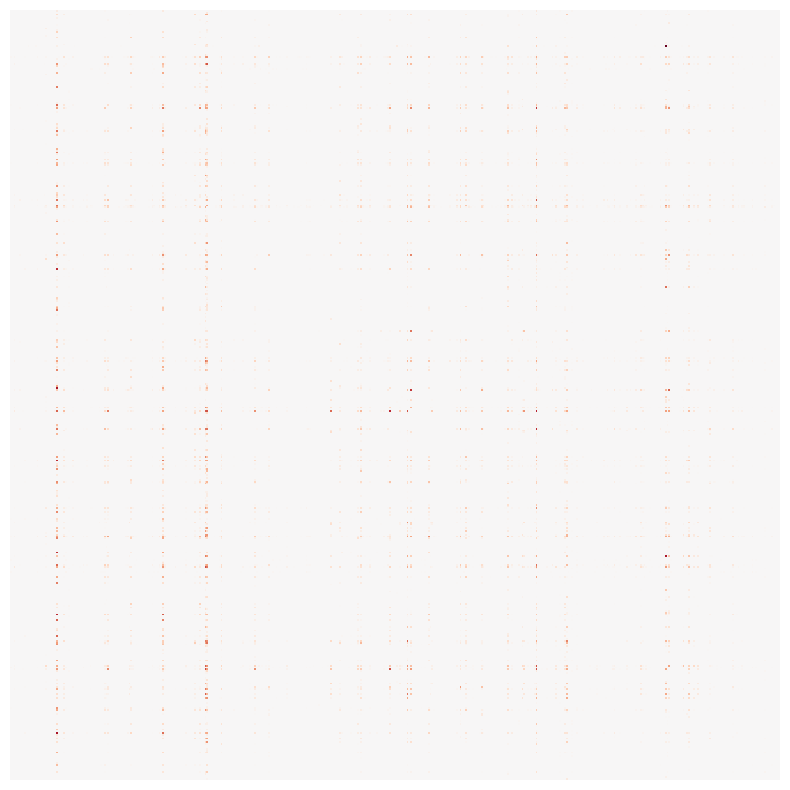

In [10]:
from graspologic.plot import heatmap
adj = nx.to_numpy_array(G, nodelist=nodelist)

heatmap(adj, cbar=False)

Observations: 
- The networkx graph is not very good 
- There are many smaller (less busy) airports that only fly to larger airports. 
- The large or busy airports are the lines that are visible on the graph. 

## Community Detection 
Next I used leiden to detect communites and to create nicer looking plots. 

Depending on resolution there could be anywhere from 3 to 45 communities. No matter the resolution the modularity was low. The modularity score for resolution of 1 was 0.18. 

(10.183902788162232, 26.191208791732787, -4.62498642206192, 9.912980568408965)

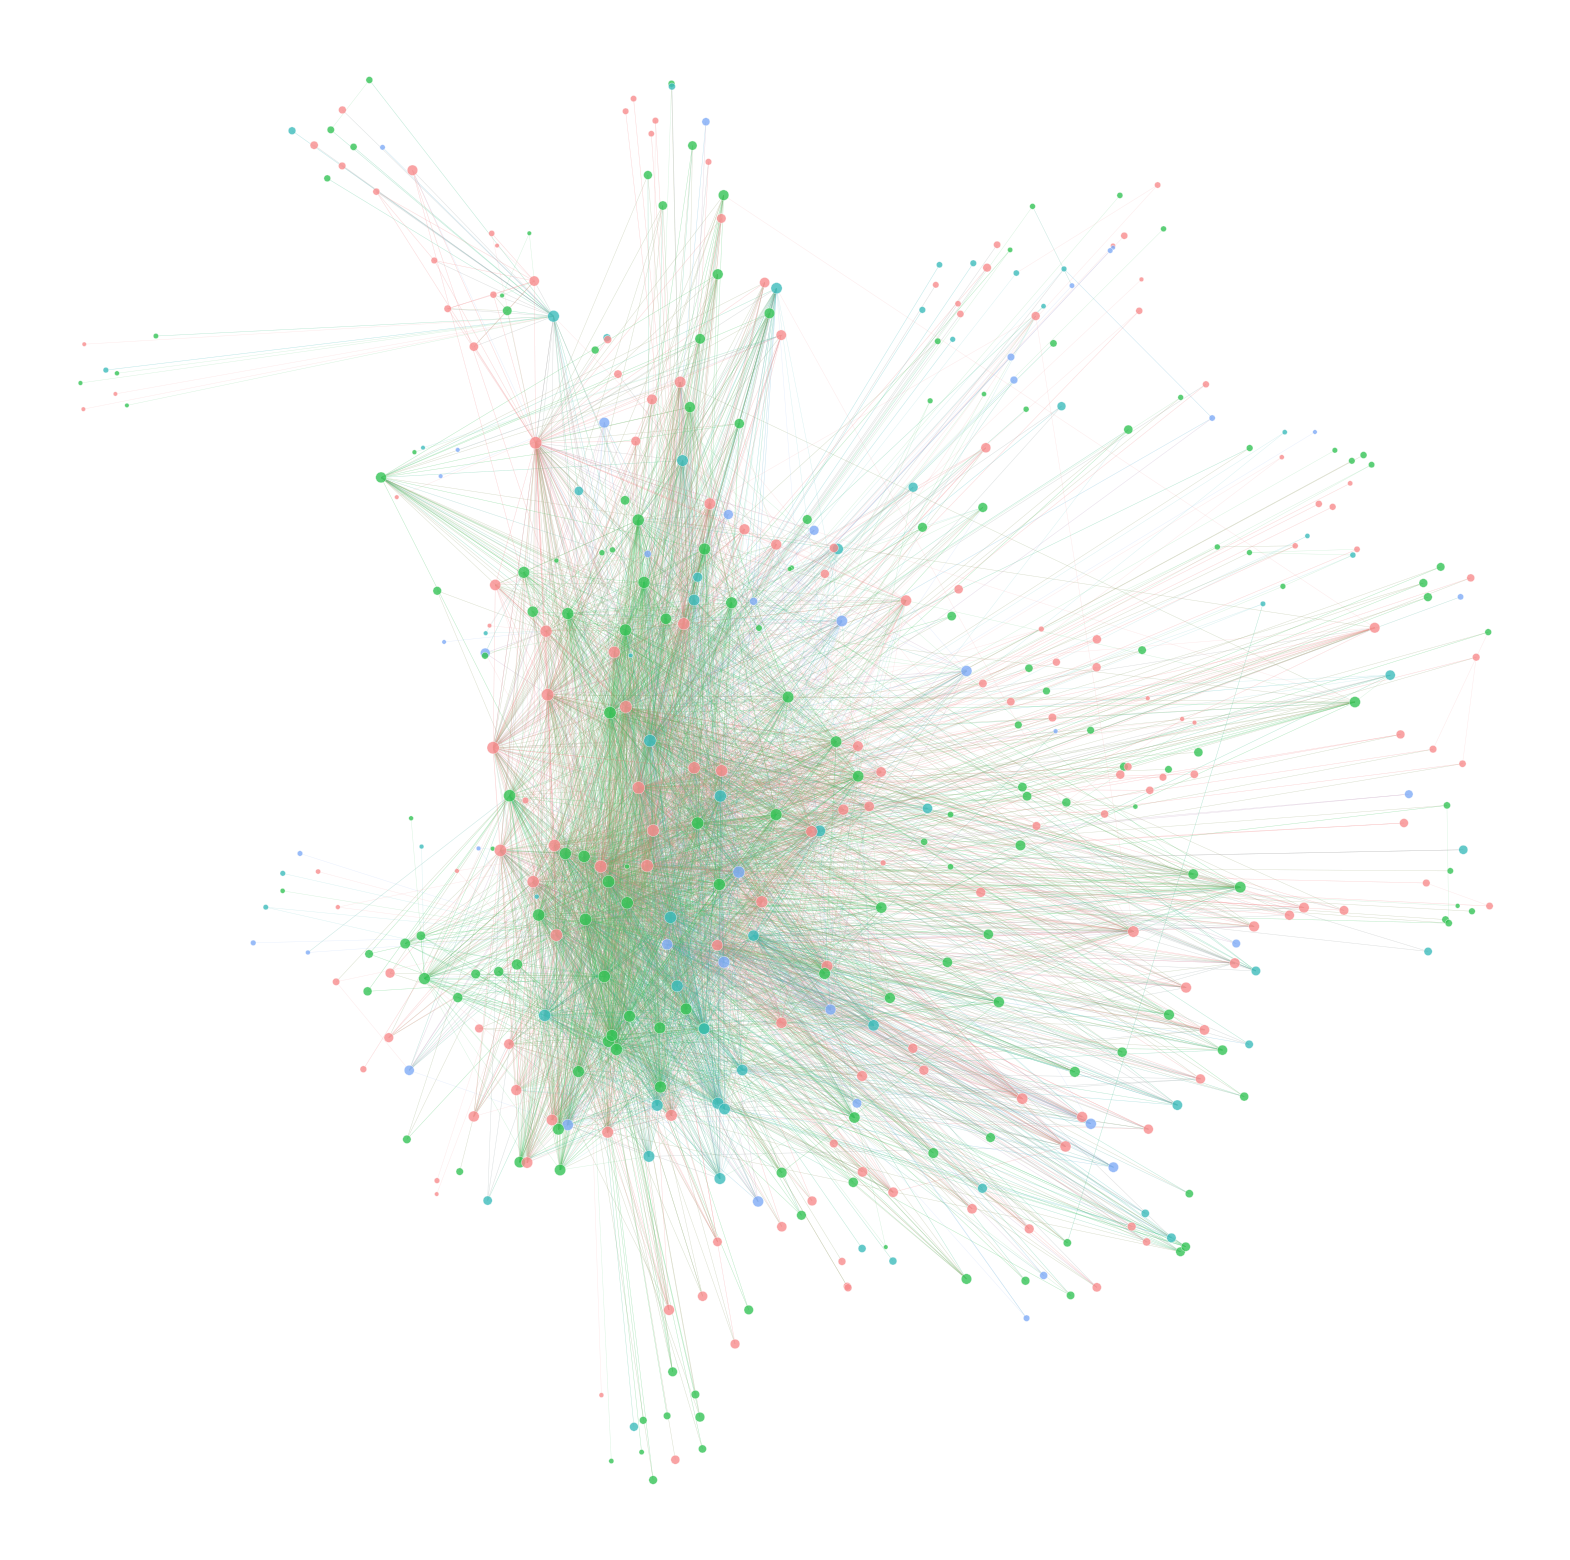

In [11]:
from graspologic.partition import leiden
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from graspologic.layouts.colors import _get_colors
from sklearn.model_selection import ParameterGrid
from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks
from umap import UMAP
from graspologic.plot import networkplot
from scipy.sparse import csr_array

main_random_state = np.random.default_rng(8888)
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = nx.Graph()
    for source, target, weight in g.edges.data("weight"):
        if sym_g.has_edge(source, target):
            sym_g[source][target]["weight"] = (
                sym_g[source][target]["weight"] + weight * 0.5
            )
        else:
            sym_g.add_edge(source, target, weight=weight * 0.5)
    return sym_g
sym_G = symmetrze_nx(G)

out = leiden(sym_G, resolution = 1)
#making a series then a dataframe with leiden data 
node_df = pd.Series(out)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()

#adding colors based on leiden communities
colors = _get_colors(True, None)["nominal"]
palette = dict(zip(node_df["community"].unique(), colors))

#graphing nodesize based on strength
adj = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

#Determining position
ptr_adj = pass_to_ranks(adj)
lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)

n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)
node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

#Plotting using graspologic  
ax = networkplot(
    adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(20, 20),
    node_hue="community",
    edge_linewidth=0.3,
    palette=palette,
)
ax.axis("off")

(6.578326630592346, 22.542750430107116, -2.098478627204895, 12.844508957862853)

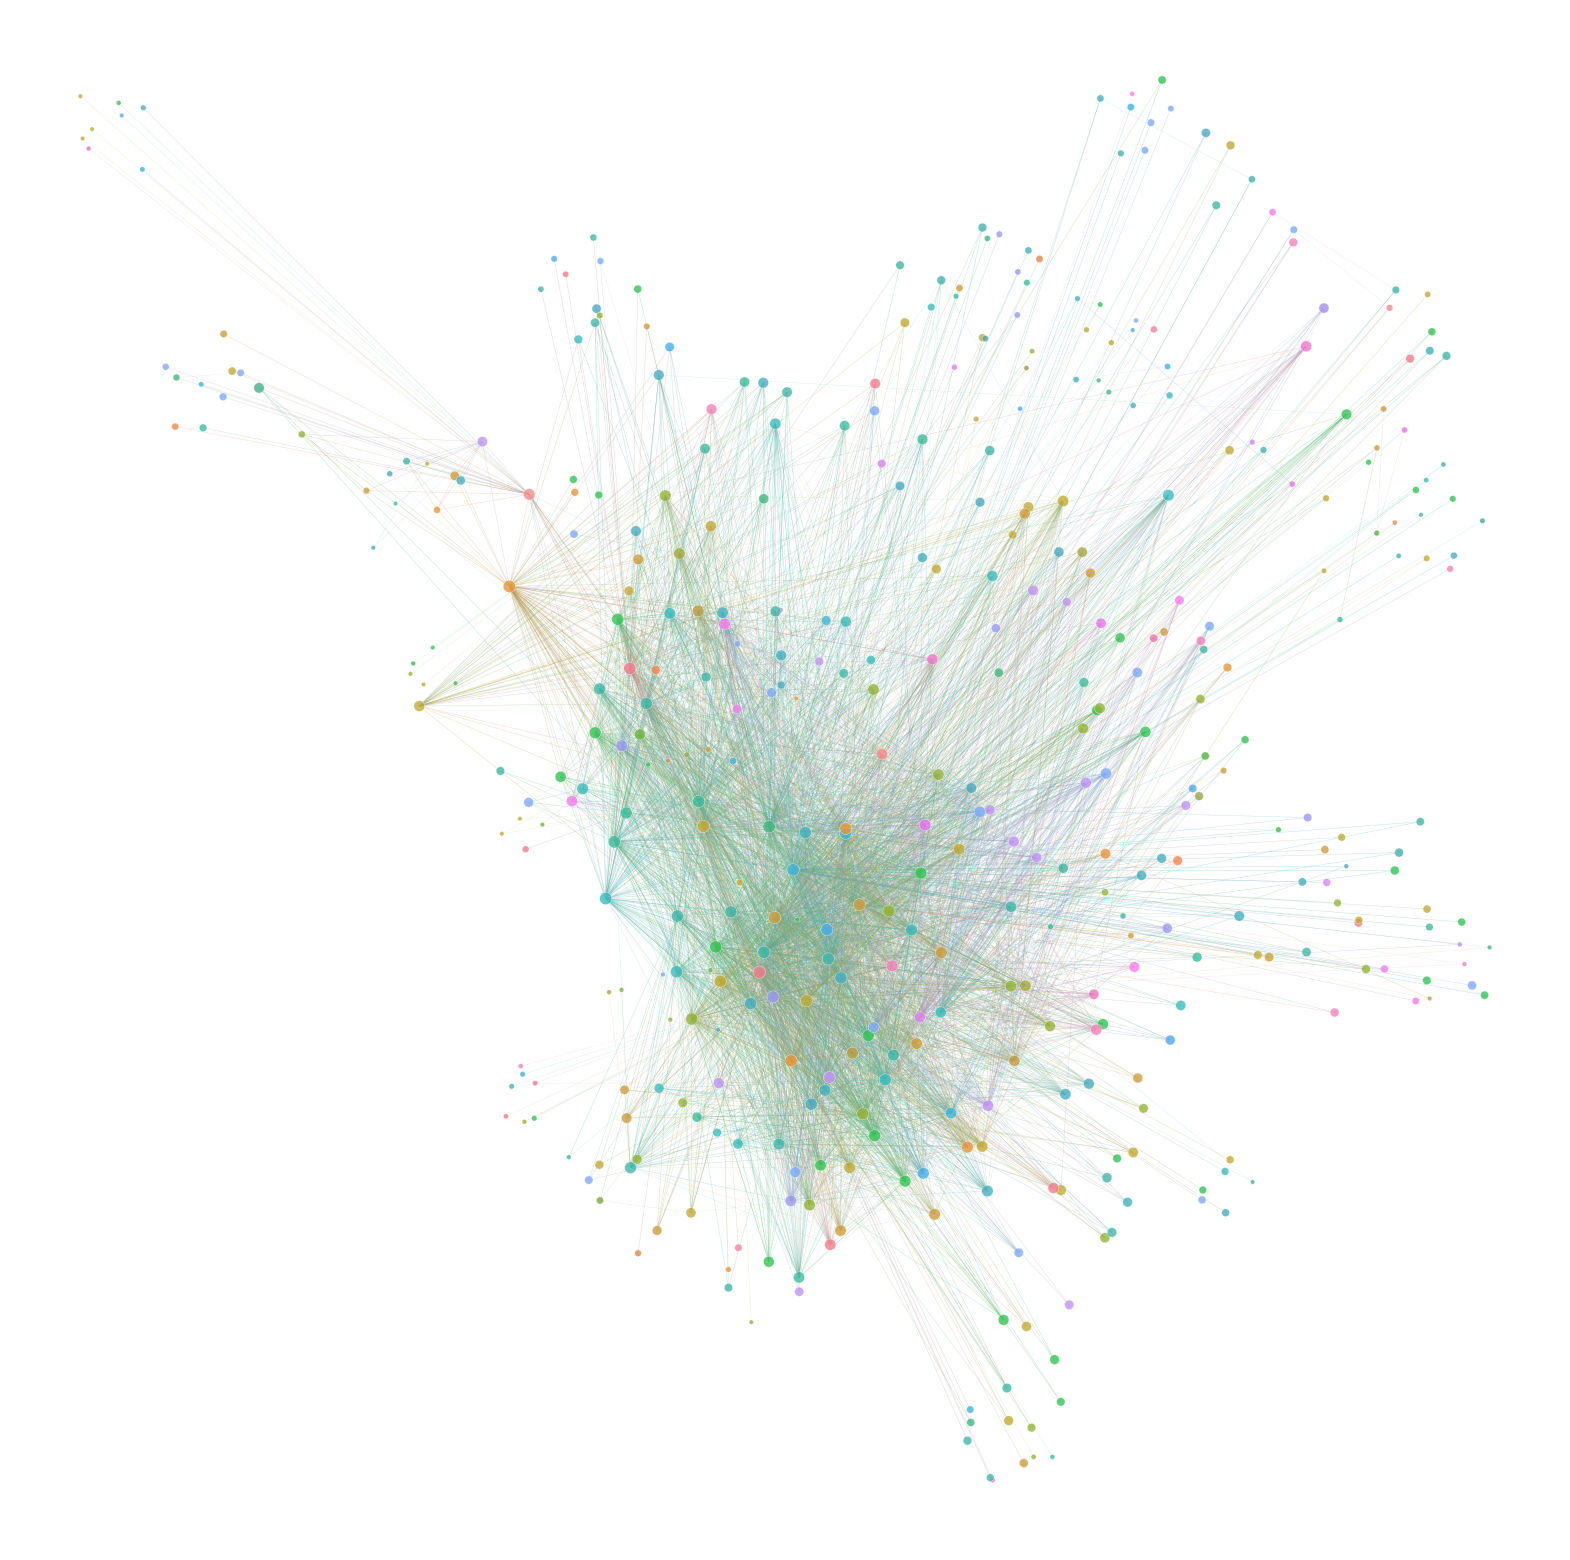

In [24]:
from graspologic.partition import leiden
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from graspologic.layouts.colors import _get_colors
from sklearn.model_selection import ParameterGrid
from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks
from umap import UMAP
from graspologic.plot import networkplot
from scipy.sparse import csr_array

main_random_state = np.random.default_rng(8888)
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = nx.Graph()
    for source, target, weight in g.edges.data("weight"):
        if sym_g.has_edge(source, target):
            sym_g[source][target]["weight"] = (
                sym_g[source][target]["weight"] + weight * 0.5
            )
        else:
            sym_g.add_edge(source, target, weight=weight * 0.5)
    return sym_g
sym_G = symmetrze_nx(G)

out = leiden(sym_G, resolution = 3)
#making a series then a dataframe with leiden data 
node_df = pd.Series(out)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()

#adding colors based on leiden communities
colors = _get_colors(True, None)["nominal"]
palette = dict(zip(node_df["community"].unique(), colors))

#graphing nodesize based on strength
adj = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

#Determining position
ptr_adj = pass_to_ranks(adj)
lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)

n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)
node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

#Plotting using graspologic  
ax = networkplot(
    adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(20, 20),
    node_hue="community",
    edge_linewidth=0.3,
    palette=palette,
)
ax.axis("off")

Even though the modularity was low, I wanted to explore if the communities had anything to do with geographic location. To do so, I sorted the data frame by community and strength to be able to investigate the most connected airports out of each community.

0 LNS, MLB, MDT, GSO, BNA
PA, FL, PA NC TN 
1 SGF, VPS, CMI, AEX, LFT 
Missouri, fl, Chicago, lousianna, lousianna 
2 PSM, PBG, IAG, BMI, PGD 
new hamsphire, NY, NY, illinos, fl
3 PIR, RIW, SOW, DRO, VDZ

Sampling 5 airports from each community at resolutions 3 and looking at their geographic locations there were usually repeated states between each community. 

HVN              2     105.0           47.0  20.941002   8.769190
FLL              2     152.0           55.0  19.784447   8.244032
MYR              2    5301.0          246.0  17.815920   6.894062
LBE
conneticut, florida, SC, CA

IWD              4     757.0          134.0  20.121136   4.697268
TVC              4     855.0          139.0  18.464842   6.809649
PAH              4    1406.0          178.0  17.020662  -1.255356
SCE              4    1882.0          193.0  12.907616   2.366777
TBN  
Michigan, michigan, kentucky, PA, Missouri

Looking at the data at a higher resolution there were still repeated cities in the data but the locations were generally not in a related geographic area. For example on community sampled had airports in Florida, Conneticut and California. This suggests that airports that are frequently flown to are not usually in the same geographic region. This makes sense because it would probably be cheaper to drive within short distance ranges. The exact way the communities are formed isn't really clear. 

In [50]:

node_df = node_df.sort_values(by=['community','strength'])
node_df

community  strength  rank_strength          x          y
node_id                                                          
DAB              0       1.0            1.0  14.213344   0.112244
ATL              0       3.0            3.0  10.702254   6.402745
CSG              0       7.0            7.0  13.378389   3.047507
MGM              0      45.0           21.0  17.104906   9.534023
TLH              0      46.0           22.0  17.120779  -1.194793
...            ...       ...            ...        ...        ...
RUT             43   41428.0          342.0  16.440046   1.811247
PVC             43   66484.0          356.0  15.186150   4.901760
AUG             43  161548.0          377.0  14.623292   2.648622
BHB             43  231327.0          384.0  11.721870   7.251369
MEM             44       7.0            7.0   7.388025  11.500373

[435 rows x 5 columns]

Some airports were very popular, and formed such strong communities that UMAP placed them very far away from the rest of the airports. These are probably cities near a major city so maybe a newark airport near New York City. It is difficult to tell exactly what these airports were as it changed everytime. 

(-2.6373936235904694,
 18.363856345415115,
 -5.282933330535888,
 15.767748928070068)

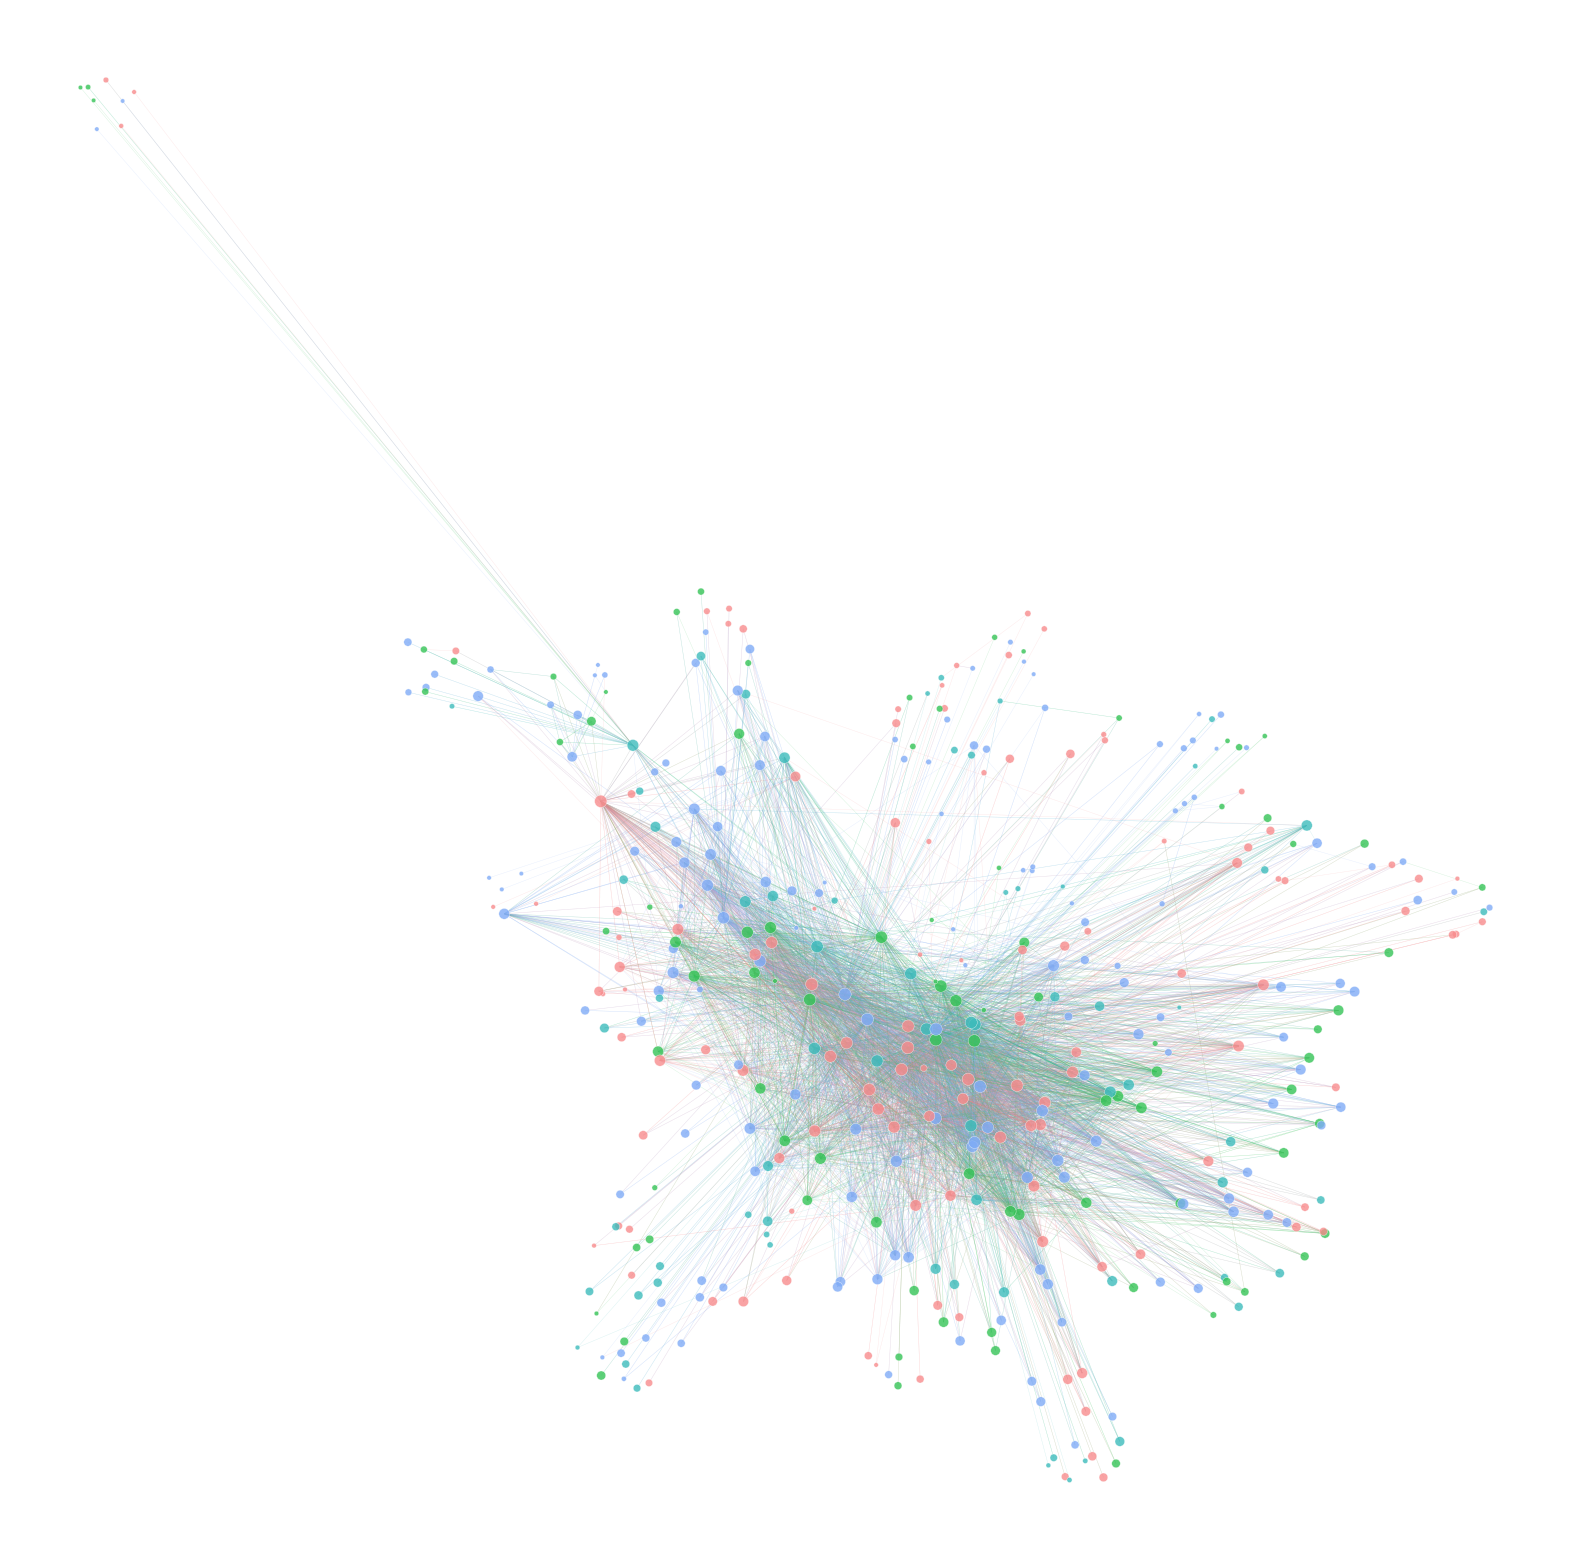

In [51]:
from graspologic.partition import leiden
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from graspologic.layouts.colors import _get_colors
from sklearn.model_selection import ParameterGrid
from graspologic.embed import LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks
from umap import UMAP
from graspologic.plot import networkplot
from scipy.sparse import csr_array

main_random_state = np.random.default_rng(8888)
def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = nx.Graph()
    for source, target, weight in g.edges.data("weight"):
        if sym_g.has_edge(source, target):
            sym_g[source][target]["weight"] = (
                sym_g[source][target]["weight"] + weight * 0.5
            )
        else:
            sym_g.add_edge(source, target, weight=weight * 0.5)
    return sym_g
sym_G = symmetrze_nx(G)

out = leiden(sym_G, resolution = 1)
#making a series then a dataframe with leiden data 
node_df = pd.Series(out)
node_df.index.name = "node_id"
node_df.name = "community"
node_df = node_df.to_frame()

#adding colors based on leiden communities
colors = _get_colors(True, None)["nominal"]
palette = dict(zip(node_df["community"].unique(), colors))

#graphing nodesize based on strength
adj = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_df["strength"] = adj.sum(axis=1) + adj.sum(axis=0)
node_df['rank_strength'] = node_df['strength'].rank(method='dense')

#Determining position
ptr_adj = pass_to_ranks(adj)
lse = LaplacianSpectralEmbed(n_components=32, concat=True)
lse_embedding = lse.fit_transform(adj)

n_components = 32
n_neighbors = 32
min_dist = 0.8
metric = "cosine"
umap = UMAP(
    n_components=2,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
)
umap_embedding = umap.fit_transform(lse_embedding)
node_df["x"] = umap_embedding[:, 0]
node_df["y"] = umap_embedding[:, 1]

#Plotting using graspologic  
ax = networkplot(
    adj,
    x="x",
    y="y",
    node_data=node_df,
    node_size="rank_strength",
    node_sizes=(10, 80),
    figsize=(20, 20),
    node_hue="community",
    edge_linewidth=0.3,
    palette=palette,
)
ax.axis("off")

## Centrality Measures
Next I tried the different centrality measures on the data. 

Looking at the centrality based on degree, it is clear that there are a few incredibly densly connnected airports that are in the center of the diagram. 

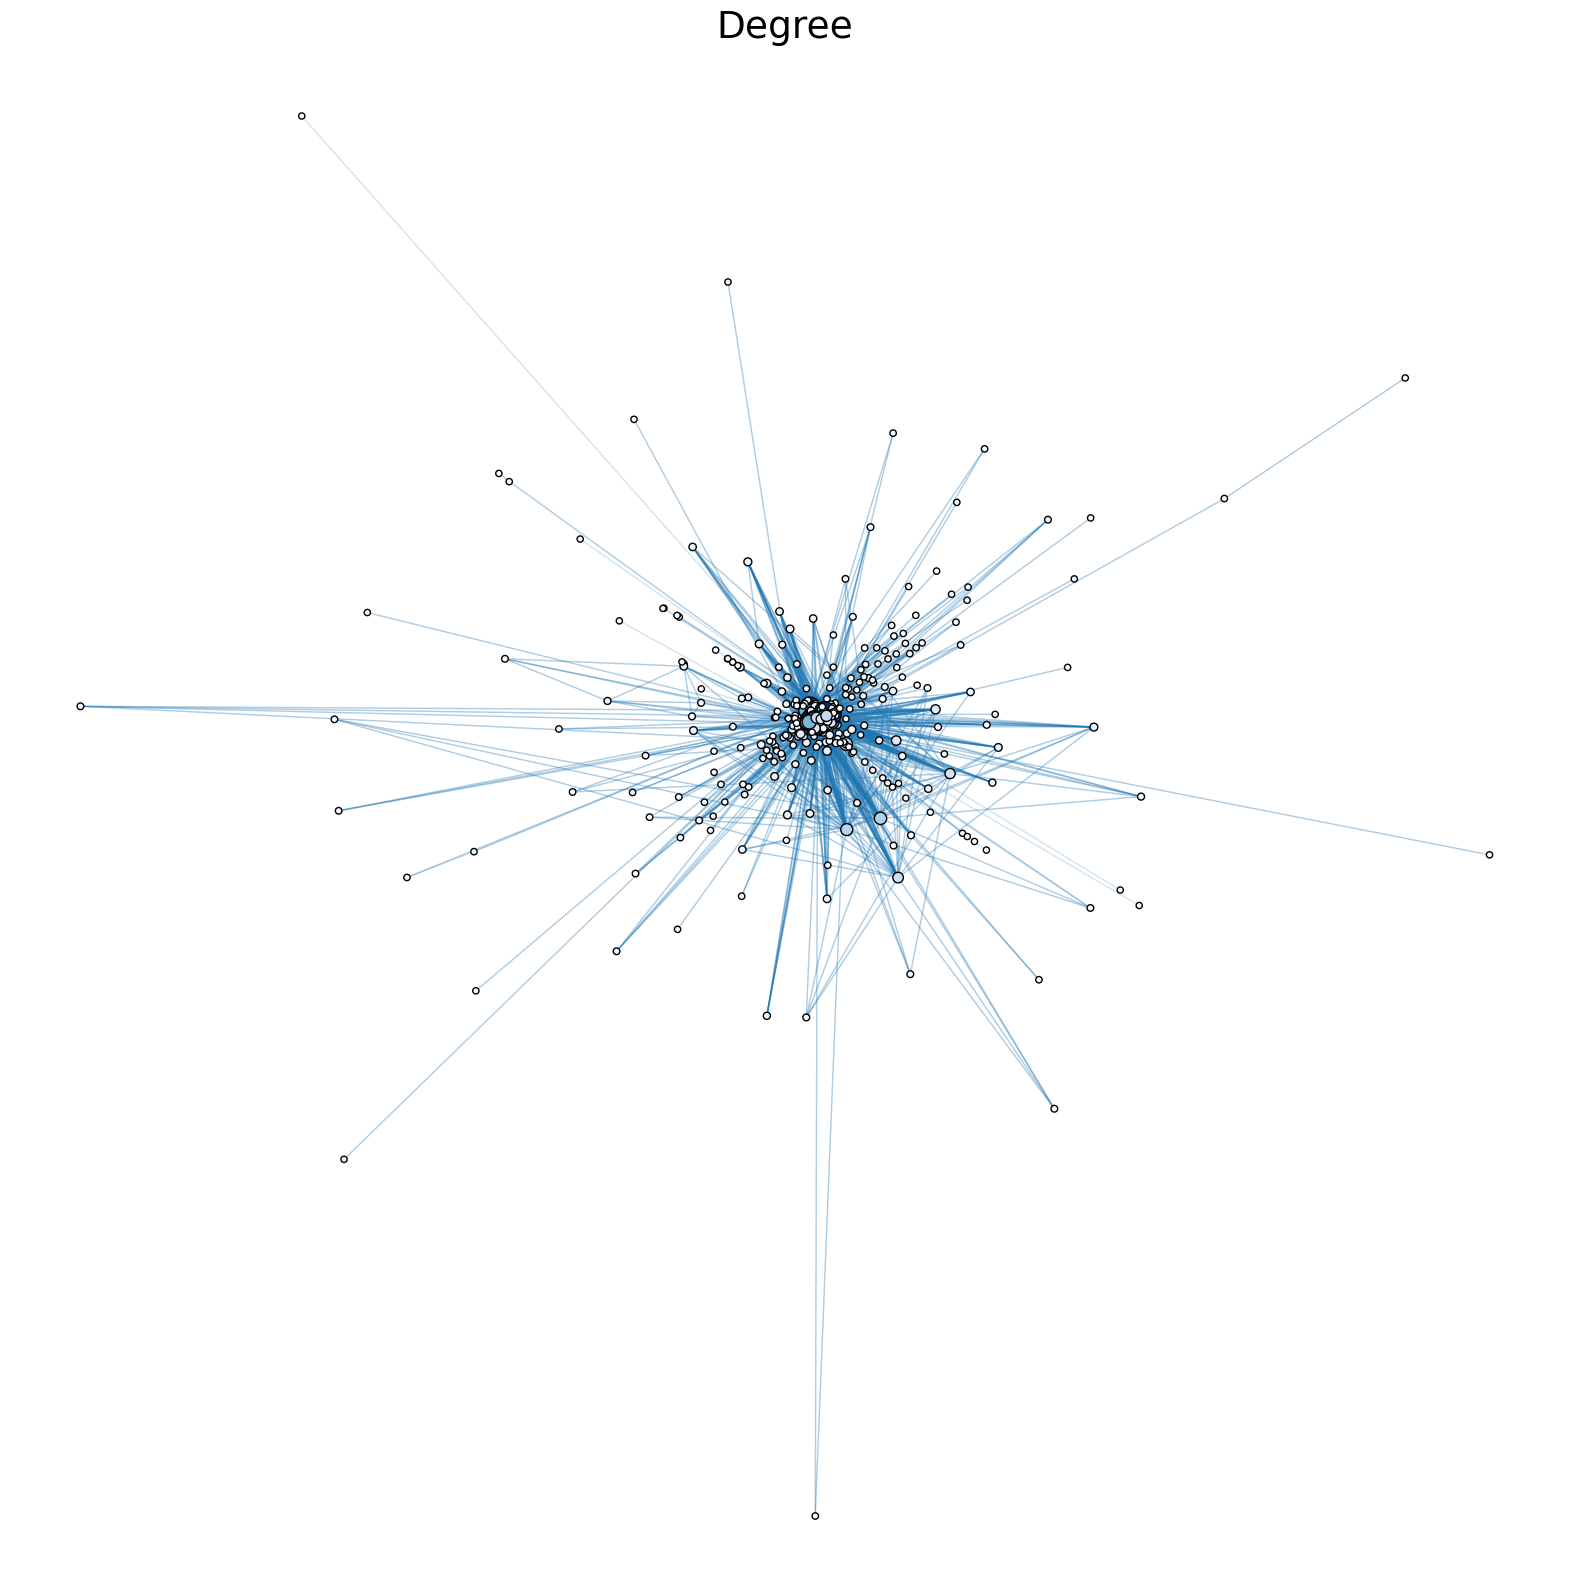

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors
import networkx as nx
A = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_data = pd.DataFrame(index=G.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(G)))

pos = nx.kamada_kawai_layout(G)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 1, figsize=(20, 20))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0]),
    )

    ax.axis("off")
    ax.set_title(key.capitalize())

ax = axs
plot_node_scaled_network(A, node_data, "degree", ax)

fig.set_facecolor("w")

I then compared all the centrality measures in the same graph. This code was based on code by Ben Pedigo. 

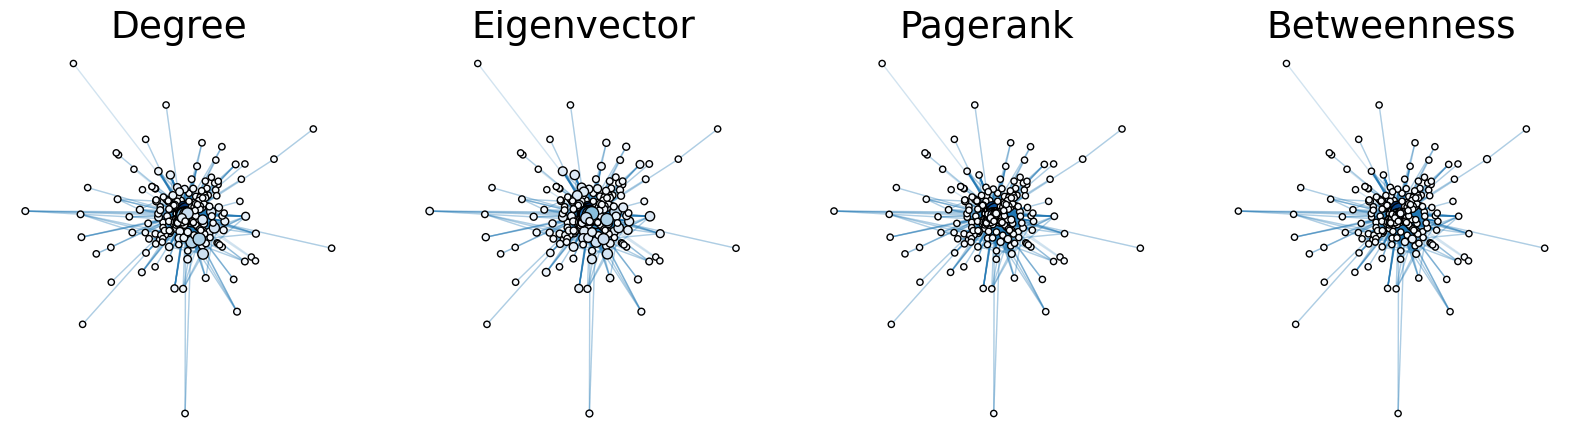

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors
import networkx as nx
A = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_data = pd.DataFrame(index=G.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(G)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(G))
node_data["pagerank"] = node_data.index.map(nx.pagerank(G))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(G))

pos = nx.kamada_kawai_layout(G)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0]),
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, "betweenness", ax)

fig.set_facecolor("w")

I used .sort_values() to rank the airports based on the different centrality measures. Then I manually added the top 10 airports to sets in order to conduct set operations. 

In [46]:
node_data = node_data.sort_values(by=['degree'])
degree = {'LAX','IAH','MSP','PHX','CLT', 'LAS', 'ATL', 'DEN', 'ORD', 'DFW'}
eigenvector = {'MDW', 'MSP','BNA', 'PHX', 'CLT', 'ATL', 'LAS','DFW','DEN','ORD'}
betweenness = {'SLC','MSP', 'PHX','LAX','LAS','SEA','CLT','ORD','DFW','ATL','DEN'}
pagerank = {'SLC','LAS','SEA','MSP','CLT','ATL','ANC','DEN','ORD','DFW'}

ConnectedAiports = degree & eigenvector
connectedaiports = betweenness & pagerank
connectedAirports = connectedaiports & ConnectedAiports

print(connectedAirports)

{'LAS', 'DFW', 'ORD', 'ATL', 'CLT', 'MSP', 'DEN'}


There were 6 airports that appeared in every centrality measure: 

Las Vegas, Atlanta, Dallas/Fort worth, Chicago O'hare, Charlotte, Minneapolis and Denver. 

The consistency between the centrality measures verifies that these airports are very highly connected. Looking at the airports it makes sense based on populaton of the cities in which these airports are located. 


These centrality measures did not account for the weight of each connection in the graph. So I compared the eigenvector plots when it was weighted and unweighted. 

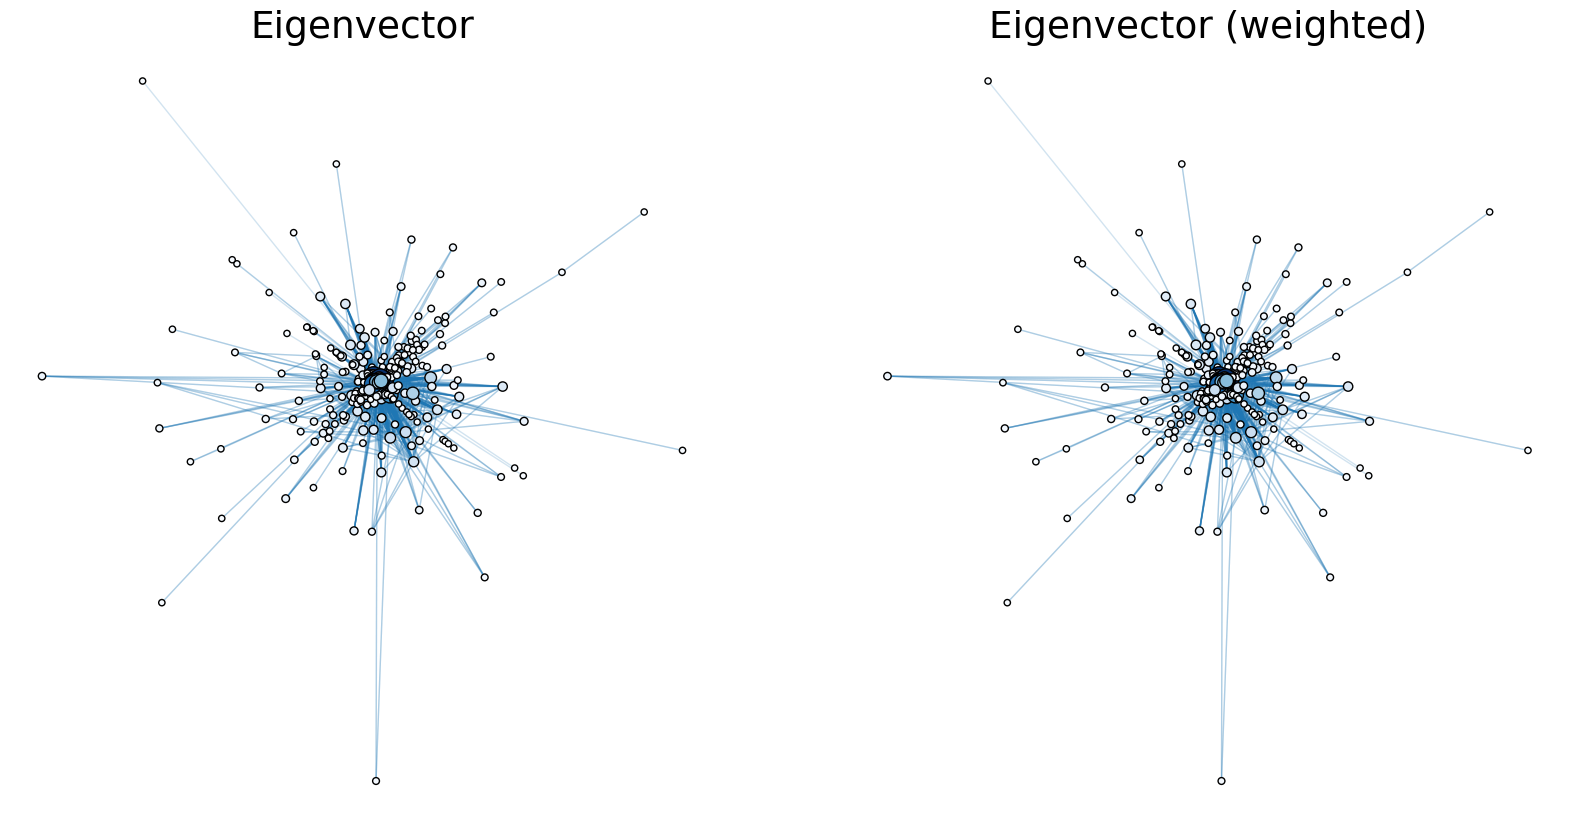

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors
import networkx as nx
A = nx.to_scipy_sparse_array(G, nodelist=nodelist)
node_data = pd.DataFrame(index=G.nodes())
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(G))
node_data["eigenvector (weighted)"] = node_data.index.map(nx.eigenvector_centrality(G))

pos = nx.kamada_kawai_layout(G)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0]),
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector (weighted)", ax)

fig.set_facecolor("w")

In [55]:
node_data = node_data.sort_values(by=['eigenvector (weighted)'])
print(node_data.to_string())

      eigenvector  eigenvector (weighted)         x         y
JMS  1.277276e-21            1.277276e-21 -0.231443  0.227580
DUJ  1.277276e-21            1.277276e-21 -0.000657  0.009819
PDT  1.277276e-21            1.277276e-21  0.022719 -0.023362
CYS  1.277276e-21            1.277276e-21 -0.506314  0.759154
PKB  1.277276e-21            1.277276e-21  0.067229 -0.072572
HRO  1.277276e-21            1.277276e-21 -0.011257  0.017871
JHM  1.277276e-21            1.277276e-21  0.011682 -0.005062
PVC  1.277276e-21            1.277276e-21  0.157823 -0.152436
IWD  1.277276e-21            1.277276e-21 -0.017577  0.018111
DVL  1.277276e-21            1.277276e-21 -0.148734  0.140681
RKD  1.277276e-21            1.277276e-21  0.076887 -0.084109
CDR  1.277276e-21            1.277276e-21  0.030904  0.001687
CDB  1.277276e-21            1.277276e-21 -0.039658  0.003241
RUT  1.277276e-21            1.277276e-21  0.090060 -0.097902
HVR  1.277276e-21            1.277276e-21 -0.080893  0.072872
SDP  1.2

Printing out the data the values were exactly the same.